In [1]:
import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import datetime
from catboost import CatBoostClassifier
import lightgbm as lgb
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import ast

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, log_loss
from sklearn import linear_model

from tqdm import tqdm_notebook as tqdm
import gc, pickle

import datetime
from catboost import CatBoostClassifier
from time import time
from collections import Counter
from scipy import stats

from sklearn import preprocessing

In [2]:
def create_is_sell_data(sell_prices_df, calendar_df, train_df):
    sell_prices_df['id'] = sell_prices_df['item_id'].astype('str')+'_'+sell_prices_df['store_id']+'_validation'
    sell_prices_data = sell_prices_df[sell_prices_df.wm_yr_wk.isin(calendar_df.wm_yr_wk.unique())]
    sell_prices_data.reset_index(drop=True, inplace=True)
    tmp = sell_prices_data.groupby(['id'])[['wm_yr_wk', 'sell_price']].apply(
        lambda x: x.set_index('wm_yr_wk')['sell_price'].to_dict()
    ).to_dict()
    d = calendar_df.d
    wm_yr_wk = calendar_df.wm_yr_wk
    price_data = {}
    for col in tqdm(train_df.id.unique()):
        price_data[col] = wm_yr_wk.map(tmp[col])
    price_data = pd.DataFrame(price_data)
    price_data.index = d
    is_sell = price_data.notnull().astype(float).T
    price_data = price_data.fillna(0)
    
    is_sell.index=train_df.id
    train_df.index=train_df.id
    is_sell = pd.concat([
        train_df[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']], is_sell
    ], axis=1)
    price_data = pd.concat([
        train_df[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']], price_data.T  
    ], axis=1)
    
    return price_data, is_sell

def set_index(df, name):
    d = {}
    for col, value in df.iloc[0,:].items():
        if type(col)==str:
            if type(df[col].values[0])!=str:
                v = 'd'
            else:
                v='id'
        else:
            v=name
        d[col]=v
    return d

def dcol2int(col):
    if col[:2]=='d_':
        return int(col.replace('d_', ''))
    else:
        return col

In [3]:
def create_category_data(data, dfT):
    C = ['item_id', 'cat_id', 'dept_id', 'store_id', 'state_id']
    tmp = dfT[C]
    tmp = tmp.to_dict()
    for key, value in tmp.items():
        data[key] = data.id.map(value)
    return data

def create_calendar_data(data, calendar_df):
    calendar_data_dict = calendar_df[['wday', 'month']].to_dict()
    for key, value in calendar_data_dict.items():
        data[key] = data.d.map(value)
    
    for shift in [-2,-1,0,1,2]:
        cols = []
        for state in ['CA', 'WI', 'TX']:
            tmp = calendar_df[f'snap_{state}'].shift(shift).to_dict()
            data[f'snap_{state}_shift{shift}'] = data.d.map(tmp)
            cols.append(f'snap_{state}_shift{shift}')
        data[f'snap_shift{shift}'] = np.nan
        for col in cols:
            state = col.replace('snap_', '').replace(f'_shift{shift}', '')
            data.loc[data['state_id']==state,f'snap_shift{shift}'] = data[col]
        data.drop(columns=cols, inplace=True)
    return data

def create_groupby_price_data(data, price_data, use_d_cols, groups=['dept_id', 'cat_id']):
    for group in groups:
        tmp = price_data[use_d_cols]/price_data.groupby([group, 'store_id'])[use_d_cols].transform('mean')
        tmp = tmp.T.astype(float)
        tmp = tmp.stack(dropna=False).reset_index()
        tmp = tmp.rename(columns=set_index(tmp, f'price_mean_by_store_{group}'))
        data = pd.merge(data, tmp, on=['d', 'id'], how='left')
        
    tmp = price_data[use_d_cols].stack().reset_index()
    tmp = tmp.rename(columns=set_index(tmp, 'price'))
    tmp.index = tmp.d.astype(str)+'_'+tmp.id.astype(str)
    tmp = tmp.price.to_dict()
    data['price'] = data.d_and_id.map(tmp)
    
    return data

In [4]:
def create_event_data(data, name):
    a = pd.concat([
        train_df.groupby(['item_id'])[d_cols].agg('mean').T.astype(float),
        calendar_df[name]
    ],axis=1)
    
    cols = a.columns[:-1]
    a[name]=a[name].fillna('NAN')
    a[cols] = a.groupby([name])[cols].transform(
        lambda x:x.sort_index().rolling(len(x), min_periods=1).mean().shift(1)
    )/train_df.groupby(['item_id'])[d_cols].agg('mean').T.astype(float).shift(1).rolling(50, min_periods=1).mean()[cols]
    
    a.loc[a[name]=='NAN', cols]=1
    a.loc[a[name]=='NAN', name]=np.nan
    a.drop(name, axis=1, inplace=True)
    
    for shift in [-3,-2,-1,0,1]:
        tmp_a = a.shift(shift).stack().reset_index()
        tmp_a = tmp_a.rename(columns=set_index(tmp_a, 'value'))
        tmp_a.index = tmp_a.id.astype(str)+'_'+tmp_a.d.astype(str)
        tmp_a = tmp_a[tmp_a.index.isin(data.d.unique().tolist())]
        tmp_a.drop(columns=['d', 'id'], inplace=True)
        data[f'{name}_shift{shift}'] = (data.item_id.astype(str)+'_'+data.d.astype(str)).map(tmp_a['value']).apply(
            lambda x: float(x) if float(x)>0 else 1
        )
    del a, tmp_a; gc.collect()
    return data

In [5]:
def create_roll_data(data, df, wins, use_d_cols):
    for win in wins:
        for agg in ['mean', 'std', 'skew', 'max', 'min']:
            tmp = df[data.id.unique()].rolling(window=win, min_periods=1).agg(agg).loc[use_d_cols].stack(dropna=False).reset_index()
            tmp = tmp.rename(columns=set_index(tmp, f'_diff_roll{win}_{agg}'))
            data = pd.merge(data, tmp, on=['d', 'id'], how='left')
        data[f'_diff_pct_roll{win}'] = data[f'_diff_roll{win}_mean']/data[f'_diff_roll{win}_std'].apply(
            lambda x: 1 if ((np.isnan(x))or(x==0)) else x
        )
    return data

def create_diff_data(data, df, i, wins, use_d_cols, name=None):
    a = abs(df.diff(i))
    for win in wins:
        for agg in ['mean']:
            tmp = a.rolling(window=win, min_periods=1).agg(agg).loc[use_d_cols].stack(dropna=False).reset_index()
            if name is None:
                tmp = tmp.rename(columns=set_index(tmp, f'abs_diff_{i}_roll{win}_{agg}'))
            else:
                tmp = tmp.rename(columns=set_index(tmp, f'{name}_abs_diff_{i}_roll{win}_{agg}'))
            data = pd.merge(data, tmp, on=['d', 'id'], how='left')
    return data

def create_group_sell_data(data, dfT, use_d_cols, groups=['dept_id', 'cat_id']):
    for group in groups:
        tmp = dfT[use_d_cols]/ dfT.groupby([group])[use_d_cols].transform('mean')
        tmp = tmp.T.astype(float)
        data = create_diff_data(data, tmp, 7, wins=[360, 30, 28, 7], use_d_cols=use_d_cols, name=f'By_{group}')
        data = create_diff_data(data, tmp, 1, wins=[360, 7], use_d_cols=use_d_cols, name=f'By_{group}')
        data = create_diff_data(data, tmp, 28, wins=[360, 7], use_d_cols=use_d_cols, name=f'By_{group}')
    return data

def create_shift_data(data, df, shifts, use_d_cols, name=None):
    ids = data.id.unique()
    tmp_df = df[ids]
    cols=[]
    for i, shift in enumerate(shifts):
        tmp = tmp_df.shift(shift).loc[use_d_cols].stack(dropna=False).reset_index()
        
        if name is None:
            tmp = tmp.rename(columns=set_index(tmp, f'shift_no{shift}'))
            cols.append(f'shift_no{shift}')
        else:
            tmp = tmp.rename(columns=set_index(tmp, f'{name}_shift_no{shift}'))
            cols.append(f'{name}_shift_no{shift}')
        data = pd.merge(data, tmp, on=['d', 'id'], how='left')
        
    cols = [cols, cols[:2], [cols[0], cols[-1]]]
    for i, col in enumerate(cols):
        if name is None:
            data[f'new_shift{i}'] = data[col].mean(1)
        else:
            data[f'new_shift{i}_{name}'] = data[col].mean(1)
    return data

def create_group_shift_data(data, df, dfT, shifts, use_d_cols):
    for group in ['dept_id', 'cat_id']:
        _tmp = dfT.groupby([group])[use_d_cols].transform('mean').T.astype(float)
        data = create_shift_data(data, _tmp, shifts, use_d_cols, name=f'By_{group}')
    return data

In [6]:
%%time
#path = '/Users/kanoumotoharu/Downloads/m5-forecasting-accuracy/'
path = '/Users/abcdm/Downloads/m5-forecasting-accuracy/'
#path = '../input/m5-forecasting-accuracy/'

train_df = pd.read_csv(path+'sales_train_validation.csv')
calendar_df = pd.read_csv(path+'calendar.csv')
sell_prices_df = pd.read_csv(path+'sell_prices.csv')
sample_submission_df = pd.read_csv(path+'sample_submission.csv')


calendar_df['d'] = calendar_df.d.str.replace('d_', '').astype(int)
cols = train_df.columns
cols = [dcol2int(col) for col in cols]
train_df.columns=cols
calendar_df['date']=pd.to_datetime(calendar_df.date)
calendar_df.index = calendar_df.d
price_data, is_sell = create_is_sell_data(sell_prices_df, calendar_df, train_df)

d_cols = [ col for col in train_df.columns if type(col)!=str ]

train_df = pd.concat([
    train_df[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']],
    train_df[d_cols]+is_sell[d_cols].replace(0, np.nan).replace(1, 0)
], axis=1)
del is_sell;gc.collect()

df = train_df.loc[:,d_cols].T.astype(float)

df = train_df.loc[:,d_cols].T.astype(float)
a = df.loc[d_cols[28:-28]].rolling(28, min_periods=1).sum().replace(0,np.nan)+df.loc[d_cols[28:-28]][::-1].rolling(28, min_periods=1).sum()[::-1].replace(0,np.nan)
a[a.notnull()]=0
df.loc[d_cols[28:-28]] += a
del a;gc.collect()


train_df[d_cols] = df.T.astype(float)

for i in range(1,29):
    train_df[d_cols[-1]+i]=np.nan
d_cols = [ col for col in train_df.columns if type(col)!=str ]


Wall time: 41.7 s


In [7]:
def make_data(ids, use_d_cols, train_d_cols, train_df, calendar_df, price_data):
    df = train_df.loc[ids,D_COLS].T.astype(float)
    df['d']=df.index

    calendar_dict = calendar_df[[
        'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1', 'event_name_2'
    ]].set_index('d').to_dict()

    for key, value in calendar_dict.items():
        df[key] = df['d'].map(value)
    df.drop('d', axis=1, inplace=True)
    price_data[
        [col for col in price_data.columns if type(col)!=str]
    ] = price_data[
        [col for col in price_data.columns if type(col)!=str]
    ].replace(0, np.nan)
    
    df = df.loc[use_d_cols,:]
    dfT = train_df.loc[ids,['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']+use_d_cols]
    price_data = price_data[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']+use_d_cols]
    
    data = df.loc[train_d_cols, ids].stack(dropna=False).reset_index().rename(columns={'level_0':'d', 'id':'id', 0:'TARGET'})

    data['d_and_id'] = data.d.astype(str)+'_'+data.id.astype(str)
    
    data = create_category_data(data, dfT)
    
    data = create_calendar_data(data, calendar_df)

    data = create_groupby_price_data(data, price_data, use_d_cols)

    for event_name in ['event_name_1', 'event_name_2']:
        tmp_df = pd.concat([
            train_df.groupby(['dept_id'])[d_cols].mean().T.astype(float),
            train_df.groupby(['cat_id'])[d_cols].mean().T.astype(float),
            calendar_df[:len(d_cols)][event_name].replace(np.nan, 'NAN')
        ],axis=1)

        dept_cols = train_df.dept_id.unique().tolist()
        cat_id_cols = train_df.cat_id.unique().tolist()

        tmp_df = pd.concat([
            tmp_df[[event_name]],
            tmp_df.groupby([event_name])[dept_cols].transform(
            lambda x: x.shift(1).rolling(len(x), min_periods=1).mean()
            ),
            tmp_df.groupby([event_name])[cat_id_cols].transform(
            lambda x: x.shift(1).rolling(len(x), min_periods=1).mean()
            )
        ], axis=1)

        tmp_df[dept_cols] = tmp_df[dept_cols]/tmp_df[dept_cols].rolling(56, min_periods=1).mean().shift(1)
        tmp_df[cat_id_cols] = tmp_df[cat_id_cols]/tmp_df[cat_id_cols].rolling(56, min_periods=1).mean().shift(1)
        tmp_df.loc[tmp_df[event_name]=='NAN', dept_cols+cat_id_cols]=1

        for shift in [0,-1,-2,-3, 1,2]:
            tmp_dic = tmp_df[dept_cols].shift(shift).to_dict()
            data[f'dept_id_{event_name}_shift{shift}']=1
            for key, value in tmp_dic.items():
                data.loc[data.dept_id==key, f'dept_id_{event_name}_shift{shift}']=data.loc[data.dept_id==key, 'd'].map(value)

        for shift in [0,-1,-2,-3, 1,2]:
            tmp_dic = tmp_df[cat_id_cols].shift(shift).to_dict()
            data[f'cat_id_{event_name}_shift{shift}']=1
            for key, value in tmp_dic.items():
                data.loc[data.cat_id==key, f'cat_id_{event_name}_shift{shift}']=data.loc[data.cat_id==key, 'd'].map(value)
        del tmp_df, tmp_dic, cat_id_cols, dept_cols;gc.collect()
        
    data = create_diff_data(data, df[ids], 7, wins=[28], use_d_cols=train_d_cols)
    data = create_diff_data(data, df[ids], 1, wins=[28, 7], use_d_cols=train_d_cols)
    data = create_diff_data(data, df[ids], 28, wins=[28], use_d_cols=train_d_cols)
    wins=[7,14,28]
    data = create_roll_data(data, df, wins, use_d_cols)
    shifts=[7,14,21,28]
    data = create_shift_data(data, df, shifts, use_d_cols)
    data = create_group_shift_data(data, df, dfT, shifts, use_d_cols)
    
    categories = [c for c in data.columns if data[c].dtype==object]
    for c in categories:
        if c=='id':
            pass
        else:
            data[c] = pd.factorize(data[c])[0]
    gc.collect()
    del data['d_and_id'];gc.collect()
    return data

In [64]:
%%time
a = train_df[d_cols].mean(1)/train_df[d_cols].std(1)
a = a.sort_values()

lag=28
D_COLS = d_cols
TARGET_D_COLS = D_COLS[-lag:]

ids = a.index.tolist()
lower_train_d_cols = D_COLS[-(lag+80):-lag]
lower_train_d_cols = lower_train_d_cols+TARGET_D_COLS
lower_use_d_cols = [i for i in range(lower_train_d_cols[0]-60,lower_train_d_cols[0])]+lower_train_d_cols
data = make_data(ids, lower_use_d_cols, lower_train_d_cols, train_df, calendar_df, price_data)

Wall time: 3min 23s


In [65]:
data.sort_values('d', inplace=True)
data.reset_index(drop=True, inplace=True)

In [66]:
gc.collect()

40

In [67]:
data.head()

,d,id,TARGET,item_id,cat_id,dept_id,store_id,state_id,wday,month,...,new_shift0_By_dept_id,new_shift1_By_dept_id,new_shift2_By_dept_id,By_cat_id_shift_no7,By_cat_id_shift_no14,By_cat_id_shift_no21,By_cat_id_shift_no28,new_shift0_By_cat_id,new_shift1_By_cat_id,new_shift2_By_cat_id
0,1834,HOUSEHOLD_2_062_TX_1_validation,1.0,0,0,0,0,0,7,2,...,0.408947,0.406901,0.402125,1.056417,0.947724,1.049355,0.979440,1.008234,1.002071,1.017928
1,1834,FOODS_2_104_CA_2_validation,0.0,2218,2,5,8,1,7,2,...,1.559889,1.373197,1.553211,1.914445,1.909945,2.285942,2.138186,2.062130,1.912195,2.026315
2,1834,HOUSEHOLD_2_277_CA_3_validation,0.0,587,0,0,9,1,7,2,...,0.408947,0.406901,0.402125,1.056417,0.947724,1.049355,0.979440,1.008234,1.002071,1.017928
3,1834,FOODS_3_246_CA_4_validation,1.0,1703,2,6,2,1,7,2,...,2.395459,2.231201,2.362825,1.914445,1.909945,2.285942,2.138186,2.062130,1.912195,2.026315
4,1834,HOUSEHOLD_1_369_CA_4_validation,1.0,2408,0,1,2,1,7,2,...,1.519782,1.508644,1.543556,1.056417,0.947724,1.049355,0.979440,1.008234,1.002071,1.017928


In [68]:
data.memory_usage().sum()/2**30

2.0854042172431946

## Train

In [69]:
PARAMS = {
    'n_estimators':2000,
    'boosting_type': 'gbdt',
    
    'objective': 'poisson',
    'metric': 'rmse',
    
    
    #'objective': 'xentropy',
    #'metric': 'xentropy',
    
    'subsample': 0.75,
    'subsample_freq': 1,
    'learning_rate': 0.07,
    'feature_fraction': 0.85,
    'max_depth': 15,
    'lambda_l1': 1,  
    'lambda_l2': 1,
    'verbose': 100,
    'random_state':123
}

In [70]:
def plot_importance(models, col, num):
    importances = np.zeros(len(col))
    for model in models:
        importances+=model.feature_importance(importance_type='gain')
    importance = pd.DataFrame()
    importance['importance'] = importances
    importance['importance'] = preprocessing.minmax_scale(importance.importance)
    importance.index = col

    plt.figure(figsize=(10,30))
    importance.sort_values('importance', ascending=True)['importance'].plot('barh')
    plt.title(f'for {num}')
    
    #importance.to_csv(f'importance_{num}.csv', index=False)
    return importance
    
def run_cv(x_train, y_train, trn_idnt_df, num, params=PARAMS):
    x_train.reset_index(drop=True,inplace=True)
    y_train.reset_index(drop=True,inplace=True)
    trn_idnt_df.reset_index(drop=True,inplace=True)
    models = []
    k = GroupKFold(n_splits=5)
    trn_idnt_df['y_pred'] = 0
    trn_idnt_df['y_true'] = 0
    
    for trn_indx, val_indx in k.split(x_train[['dept_id']],groups=x_train['dept_id']):
        train_set = lgb.Dataset(x_train.loc[trn_indx,:], y_train.loc[trn_indx])
        val_set = lgb.Dataset(x_train.loc[val_indx,:], y_train.loc[val_indx])
        
        categories = ['cat_id', 'dept_id', 'store_id']
        
        model = lgb.train(
            train_set=train_set, 
            valid_sets=[train_set, val_set],
            params=params, num_boost_round=3000, early_stopping_rounds=100, verbose_eval=500,
            categorical_feature=categories+['wday', 'month']
        )
        
        models.append(model)
        trn_idnt_df.loc[val_indx, 'y_pred']=np.e**(model.predict(x_train.loc[val_indx,:]))-1
        trn_idnt_df.loc[val_indx, 'y_true']=np.e**(y_train.loc[val_indx])-1
        gc.collect()
    
    #trn_idnt_df.to_csv(f'trn_idnt_df_{num}.csv', index=False)
    return models, trn_idnt_df

def predict_cv(x_val, models):
    preds = np.zeros(len(x_val))
    
    for  model in models:
        preds+=model.predict(x_val)/len(models)
    return preds

def show_eval_score(preds, y_val, val_idnt_df, num):
    
    #score = log_loss(y_val, preds)
    preds = np.e**(preds)-1
    y_val = np.e**(y_val)-1
    
    print(y_val)
    score= np.sqrt(mean_squared_error(y_val, preds))
    
    val_idnt_df.reset_index(drop=True,inplace=True)
    val_idnt_df['y_true'] = y_val.values
    val_idnt_df['y_preds'] = preds
    val_idnt_df
    print("EVALUATION SCORE : ", score)
    
    return val_idnt_df
    
def shift_data(_data, for_predict):
    # for_predict 1~28
    data = _data.copy()
    diff_cols = [col for col in data.columns if ('diff' in col)]
    shift_cols = [
        col for col in data.columns if ('shift' in col) and (not 'diff' in col)and (not 'snap' in col)and(not 'event' in col)
    ]
    data = pd.concat([
        data.drop(columns=diff_cols),
        data[diff_cols+['id']].groupby(['id']).transform(
            lambda x: x.sort_index().shift(for_predict)
        )
    ], axis=1)
    if (for_predict-1)>0 and (for_predict-1)%7==0: 
        data = pd.concat([
            data.drop(columns=shift_cols),
            data[shift_cols+['id']].groupby(['id']).transform(
                lambda x: x.sort_index().shift(for_predict-1)
            )
        ],axis=1)
    
    data =pd.concat([
        data['id'],
        data[[c for c in data.columns if c!='id']].astype(float)
    ], axis=1)
    
    return data

def split_data(data, train_d_cols, split):
    y = data[data.TARGET.notnull()][['TARGET']+['d', 'id']]
    
    y['TARGET'] = np.log1p(y['TARGET'])
    #y['TARGET'] = y['TARGET'].apply(lambda x: 1.0 if x>0 else 0.0)
    
    X = data[data.TARGET.notnull()].drop(columns=['id',  'TARGET', 'item_id','state_id']).astype(float)
    
    d_cols = sorted(y.d.unique())
    x_train, x_val = X[X.d.isin(d_cols[:-split])], X[X.d.isin(d_cols[-split:])]
    y_train, y_val = y[y.d.isin(d_cols[:-split])], y[y.d.isin(d_cols[-split:])]
    
    trn_idnt_df = y_train[['id', 'd']]
    val_idnt_df = y_val[['id', 'd']]
    
    x_train.drop('d', axis=1, inplace=True)
    x_val.drop('d', axis=1, inplace=True)
    y_train = y_train['TARGET'].astype(float)
    y_val = y_val['TARGET'].astype(float)
    
    return x_train, x_val, y_train, y_val, trn_idnt_df, val_idnt_df

def train(data, for_predict):
    train_d_cols = data.d.unique().tolist()
    split=28
    
    print("""
###########################################
    ############## {} ###############
###########################################""".format(for_predict)
         )
    
    _data = shift_data(data, for_predict)
    x_train, x_val, y_train, y_val, trn_idnt_df, val_idnt_df = split_data(_data, train_d_cols, split)
    print(x_train.shape, x_val.shape)
    models, trn_idnt_df = run_cv(x_train, y_train, trn_idnt_df, for_predict)
    preds = predict_cv(x_val, models)
    score_df = show_eval_score(preds, y_val, val_idnt_df, for_predict)
    importance = plot_importance(models, x_train.columns, for_predict)
    
    del _data, x_train, x_val, y_train, y_val;gc.collect()
    return models, score_df, importance, trn_idnt_df

In [71]:
for_predict = 1


###########################################
    ############## 1 ###############
###########################################
(1345832, 80) (853720, 80)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[372]	training's rmse: 0.484185	valid_1's rmse: 0.551431
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[315]	training's rmse: 0.499259	valid_1's rmse: 0.516931
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[352]	training's rmse: 0.519555	valid_1's rmse: 0.389859
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[275]	training's rmse: 0.508824	valid_1's rmse: 0.473052
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.488308	valid_1's rmse: 0.548631
Early stopping, best iteration is:
[577]	training's rmse: 0.48769	valid_1's rmse: 0.548542
1585480    1.0
158548

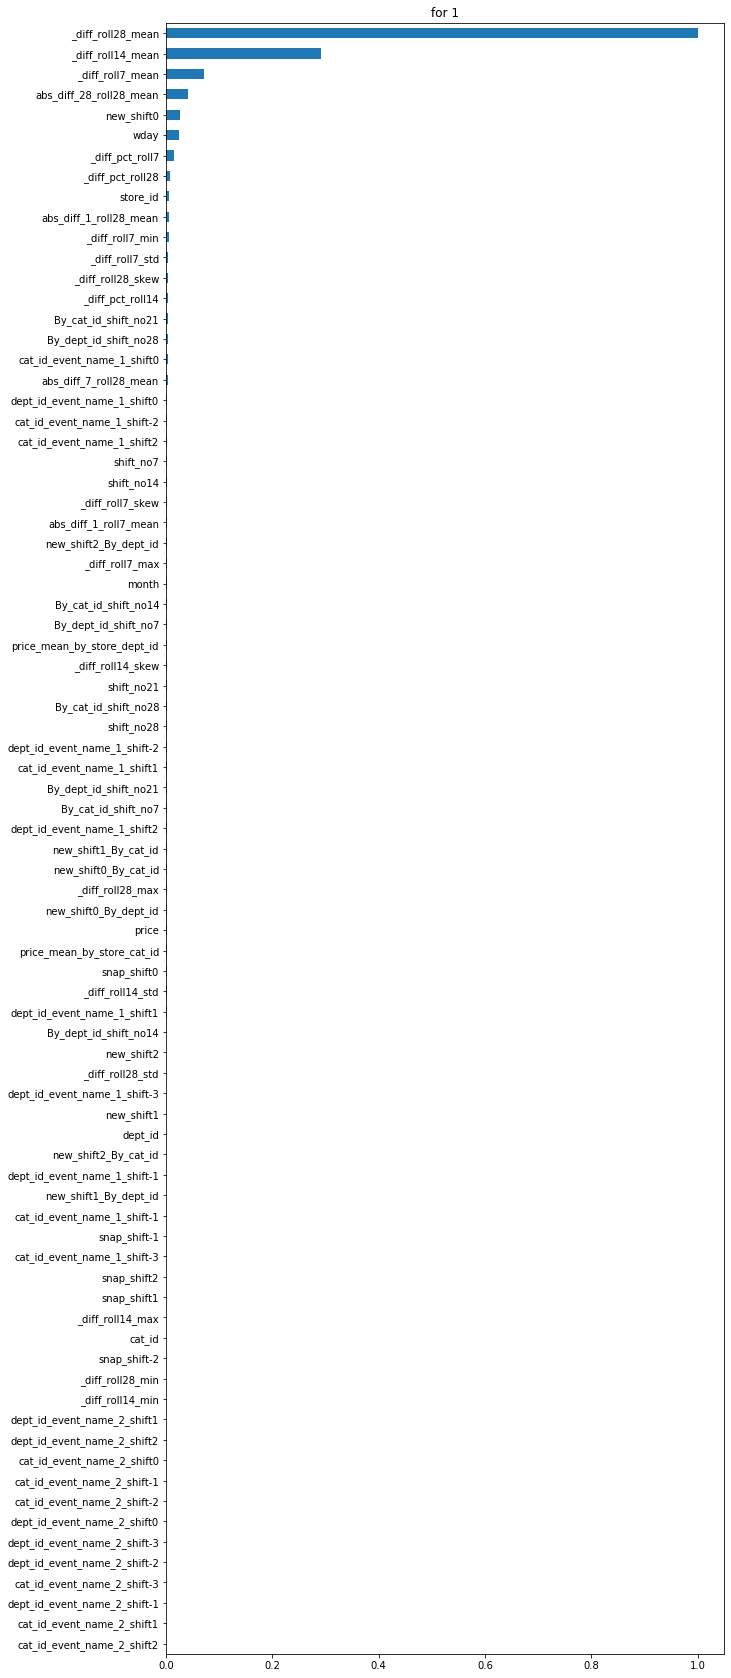

In [72]:
%%time
models, normal_score_df, importance, trn_cv_df = train(data, for_predict)

In [73]:
gc.collect()

11896

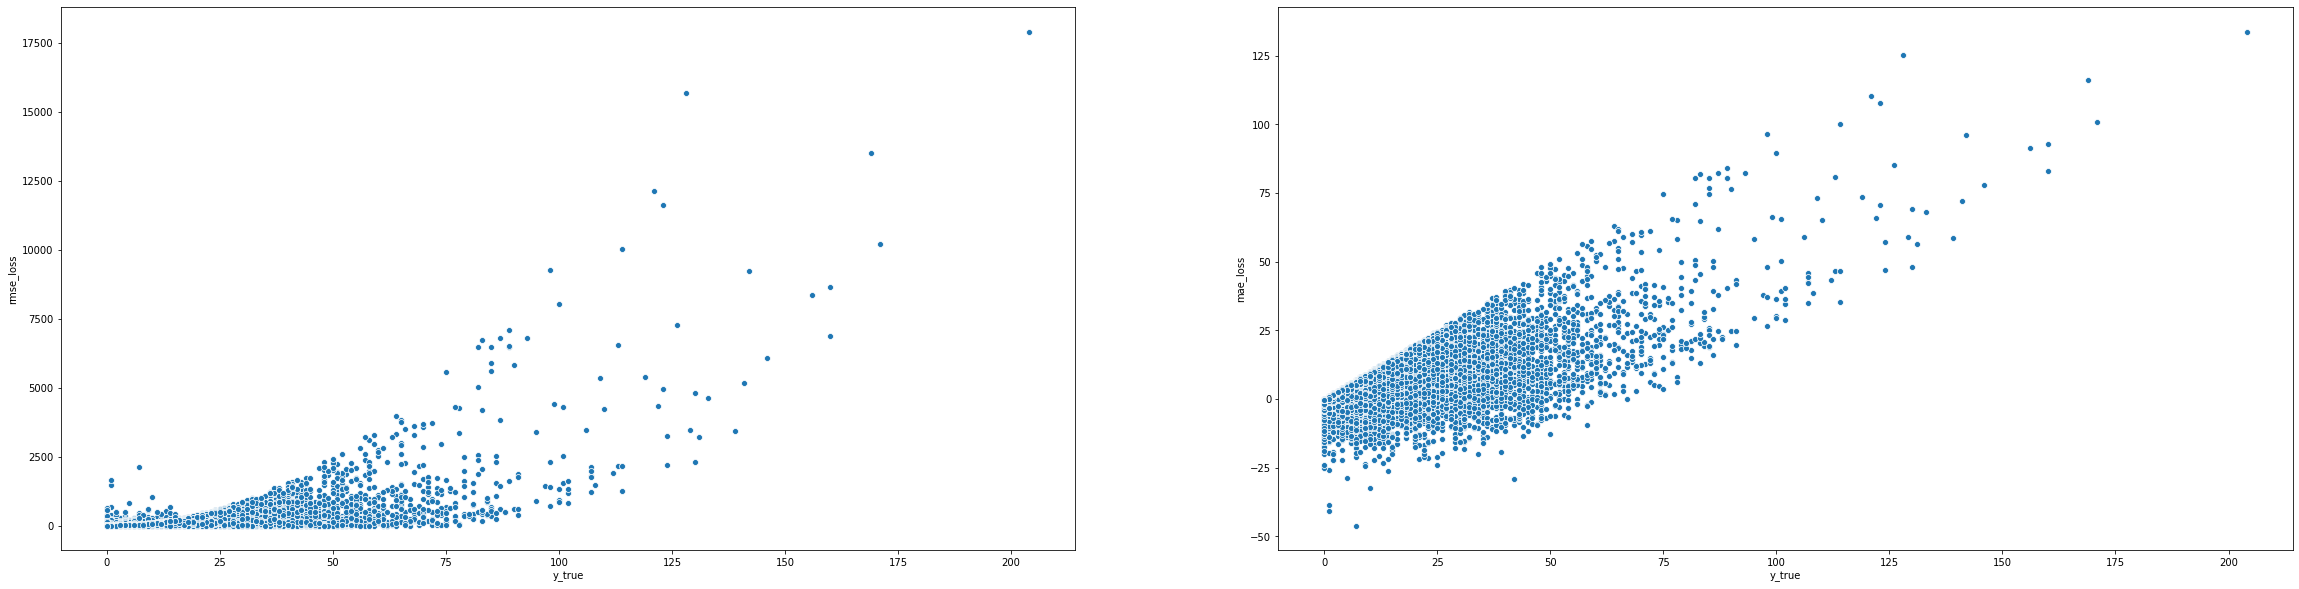

In [74]:
normal_score_df['rmse_loss'] = (normal_score_df.y_true-normal_score_df.y_preds)**2
normal_score_df['mae_loss'] = normal_score_df.y_true-normal_score_df.y_preds
plt.figure(figsize=(40,10))
plt.subplot(1,2,1)
sns.scatterplot(normal_score_df.y_true, normal_score_df.rmse_loss)
plt.subplot(1,2,2)
sns.scatterplot(normal_score_df.y_true, normal_score_df.mae_loss)

In [75]:
def fill_na_mean(data):
        for i in [7,14,21,28]:
            data.loc[
                data[f'shift_no{i}'].isnull(),f'shift_no{i}'
            ] = data.loc[
                data[f'shift_no{i}'].isnull(),:
            ].iloc[
                :,((data.columns.str.startswith('shift'))|(data.columns.str.startswith('new_shift')))&(~data.columns.str.contains('By'))
            ].mean(1)
            
        for agg in ['mean', 'std', 'skew', 'max', 'min']:
            cols = data.columns[(data.columns.str.startswith('_diff_roll'))&(data.columns.str.endswith(agg))]
            for col in cols:
                data.loc[data[col].isnull(),col] = data.loc[data[col].isnull(),cols].mean(1)
                
        for agg in ['mean']:
            cols = data.columns[(data.columns.str.startswith('abs_diff_'))|(data.columns.str.startswith(agg))]
            for col in cols:
                data.loc[data[col].isnull(),col] = data.loc[data[col].isnull(),cols].mean(1)
        for by_col in ['By_dept_id', 'By_cat_id']:
            cols = data.columns[data.columns.str.startswith(by_col)]
            for col in cols:
                data.loc[data[col].isnull(),col] = data.loc[data[col].isnull(),cols].mean(1)
        return data
    
def to_onehot_data(data):
    category = ['item_id', 'cat_id', 'dept_id', 'store_id', 'state_id', 'month', 'wday']
    for cat in category:
        data = pd.concat([
            data.drop(cat, axis=1),
            pd.get_dummies(data[cat]).rename(columns={i:f'{cat}_{int(i)}' for i in data[cat].unique()})
        ], axis=1)
    return data

In [76]:
trn_days = trn_cv_df.d.unique()
val_days = normal_score_df.d.unique()

In [77]:
np.sqrt(mean_squared_error(np.e**(trn_cv_df.y_pred)+1, np.e**(trn_cv_df.y_true)+1))

2.547480274851951

In [79]:
normal_score_df.head()

,id,d,y_true,y_preds,rmse_loss,mae_loss
0,HOUSEHOLD_2_212_WI_3_validation,1886.0,1.0,0.674354,0.106046,0.325646
1,HOUSEHOLD_1_193_CA_4_validation,1886.0,1.0,0.908393,0.008392,0.091607
2,FOODS_3_241_CA_3_validation,1886.0,1.0,2.127075,1.270299,-1.127075
3,FOODS_2_334_TX_1_validation,1886.0,0.0,0.514369,0.264576,-0.514369
4,FOODS_3_246_CA_4_validation,1886.0,0.0,0.865249,0.748656,-0.865249


In [82]:
trn_cv_df.head()

,id,d,y_pred,y_true
0,HOUSEHOLD_2_062_TX_1_validation,1834.0,1.258714,2.0
1,FOODS_2_104_CA_2_validation,1834.0,1.248837,1.0
2,HOUSEHOLD_2_277_CA_3_validation,1834.0,1.615378,1.0
3,FOODS_3_246_CA_4_validation,1834.0,1.805412,2.0
4,HOUSEHOLD_1_369_CA_4_validation,1834.0,1.454041,2.0


### upper optimazation

In [83]:
%%time

del data;print(gc.collect())

ids = normal_score_df[normal_score_df.y_preds>10].id.unique().tolist()
train_d_cols = D_COLS[-(lag+400):-lag]
train_d_cols = train_d_cols+TARGET_D_COLS
use_d_cols = [i for i in range(train_d_cols[0]-60,train_d_cols[0])]+train_d_cols
data = make_data(ids, use_d_cols, train_d_cols, train_df, calendar_df, price_data)
data.sort_values('d', inplace=True)
data.reset_index(drop=True, inplace=True)

2264
Wall time: 56.8 s


In [84]:
data = fill_na_mean(data)
data = to_onehot_data(data)

In [85]:
data = shift_data(data, for_predict)

In [86]:
data.dropna(0, inplace=True); gc.collect()

29

In [88]:
data.memory_usage().sum()/2**30

0.6152734756469727

In [173]:
train = data[data.d.isin(trn_days)]
val = data[data.d.isin(val_days)]
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
print(train.shape, val.shape)

(32536, 351) (18145, 351)


In [174]:
from sklearn.linear_model import Ridge,Lasso
from sklearn.neural_network import MLPRegressor

In [175]:
def linear_fitting(X, y):
    ridge = Ridge()
    lasso = Lasso()
    
    ridge.fit(X,y)
    lasso.fit(X,y)
    models = {}
    models['ridge'] = ridge
    models['lasso'] = lasso
    return models
def linear_predict(models, X):
    preds={}
    for name, model in models.items():
        preds[f'{name}_preds'] = model.predict(X)
    return preds

In [176]:
models = linear_fitting(
    train.drop(columns=['id', 'd', 'TARGET']),
    train['TARGET']
)

In [177]:
train_preds = linear_predict(models, train.drop(columns=['id', 'd', 'TARGET']))
val_preds = linear_predict(models, val.drop(columns=['id', 'd', 'TARGET']))

In [178]:
for name, preds in train_preds.items():
    train[name] = preds
for name, preds in val_preds.items():
    val[name] = preds

In [179]:
train = train[['id', 'd', 'ridge_preds', 'lasso_preds' ]]
val = val[['id', 'd', 'ridge_preds', 'lasso_preds' ]]
gc.collect()

38414

In [191]:
upper_trn_cv_df = pd.merge(trn_cv_df,train,on=['id', 'd'],how='outer')
upper_normal_score_df = pd.merge(normal_score_df,val, on=['id', 'd'],how='outer')

In [195]:
upper_trn_cv_df = upper_trn_cv_df[upper_trn_cv_df.ridge_preds.notnull()]
upper_normal_score_df = upper_normal_score_df[upper_normal_score_df.ridge_preds.notnull()]

upper_trn_cv_df.shape, upper_normal_score_df.shape

((32536, 6), (18145, 8))

In [248]:
mlp = MLPRegressor(solver='adam', early_stopping=True)

In [249]:
upper_trn_cv_df

,id,d,y_pred,y_true,ridge_preds,lasso_preds
111,FOODS_3_154_WI_3_validation,1834.0,9.143377,24.0,14.573184,13.751642
127,FOODS_3_412_WI_2_validation,1834.0,1.600895,129.0,14.760009,8.309473
171,FOODS_2_183_WI_2_validation,1834.0,9.992281,10.0,10.543099,10.553154
186,FOODS_3_498_WI_2_validation,1834.0,1.600895,2.0,24.261831,26.467227
346,FOODS_3_150_CA_3_validation,1834.0,3.840794,7.0,7.723459,6.383876
...,...,...,...,...,...,...
1343025,HOUSEHOLD_1_474_TX_2_validation,1885.0,14.661036,5.0,16.530577,15.631813
1343582,FOODS_3_404_TX_3_validation,1885.0,13.081233,12.0,13.888350,14.728696
1344596,FOODS_3_313_TX_1_validation,1885.0,9.808205,13.0,11.044620,10.608646
1344765,FOODS_3_313_TX_3_validation,1885.0,10.659379,10.0,11.406638,12.014448


In [250]:
mlp.fit(upper_trn_cv_df[['y_pred', 'ridge_preds', 'lasso_preds']], upper_trn_cv_df['y_true'])

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [251]:
upper_normal_score_df['mlp_preds'] = mlp.predict(upper_normal_score_df[['y_preds', 'ridge_preds', 'lasso_preds']])

In [252]:
normal_score_df['_key'] = normal_score_df.id.astype(str)+'_'+normal_score_df.d.astype(str)
upper_normal_score_df['_key'] = upper_normal_score_df.id.astype(str)+'_'+upper_normal_score_df.d.astype(str)

In [260]:
normal_score_df['mlp_preds'] = normal_score_df['_key'].map(upper_normal_score_df.set_index('_key')['mlp_preds'].to_dict())
normal_score_df['ridge_preds'] = normal_score_df['_key'].map(upper_normal_score_df.set_index('_key')['ridge_preds'].to_dict())

In [261]:
normal_score_df.loc[
    normal_score_df.mlp_preds.isnull(),'mlp_preds'
] = normal_score_df.loc[
    normal_score_df.mlp_preds.isnull(),'y_preds'
]
normal_score_df.loc[
    normal_score_df.ridge_preds.isnull(),'ridge_preds'
] = normal_score_df.loc[
    normal_score_df.ridge_preds.isnull(),'y_preds'
]

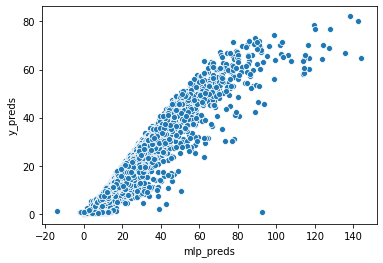

In [262]:
sns.scatterplot(upper_normal_score_df['mlp_preds'], upper_normal_score_df.y_preds)

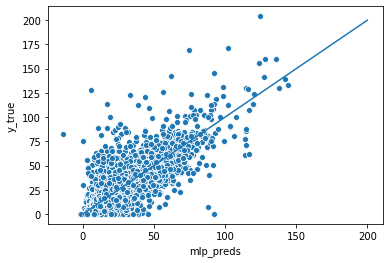

In [263]:
sns.scatterplot(upper_normal_score_df['mlp_preds'], upper_normal_score_df.y_true)
plt.plot([0,200], [0,200])

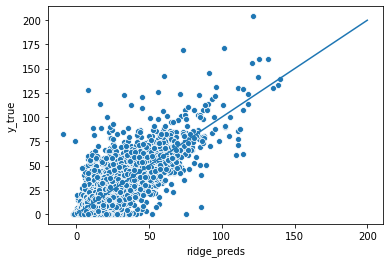

In [264]:
sns.scatterplot(upper_normal_score_df['ridge_preds'], upper_normal_score_df.y_true)
plt.plot([0,200], [0,200])

In [266]:
print(
    np.sqrt(mean_squared_error(normal_score_df['mlp_preds'], normal_score_df.y_true)),
    np.sqrt(mean_squared_error(normal_score_df['y_preds'], normal_score_df.y_true)),
    np.sqrt(mean_squared_error(normal_score_df['ridge_preds'], normal_score_df.y_true))
)

2.0215459486030514 2.092972788762584 2.018800948235081


### middle optimazation

In [ ]:
"""
ids = a.index.tolist()
lower_train_d_cols = D_COLS[-(lag+120):-lag]
lower_train_d_cols = lower_train_d_cols+TARGET_D_COLS
lower_use_d_cols = [i for i in range(lower_train_d_cols[0]-60,lower_train_d_cols[0])]+lower_train_d_cols
data = make_data(ids, lower_use_d_cols, lower_train_d_cols, train_df, calendar_df, price_data)
data.sort_values('d', inplace=True)
data.reset_index(drop=True, inplace=True)
"""

### lower optimazation

In [ ]:
"""
ids = a.index.tolist()
lower_train_d_cols = D_COLS[-(lag+120):-lag]
lower_train_d_cols = lower_train_d_cols+TARGET_D_COLS
lower_use_d_cols = [i for i in range(lower_train_d_cols[0]-60,lower_train_d_cols[0])]+lower_train_d_cols
data = make_data(ids, lower_use_d_cols, lower_train_d_cols, train_df, calendar_df, price_data)
data.sort_values('d', inplace=True)
data.reset_index(drop=True, inplace=True)
"""

In [ ]:
normal_score_df